[Reference](https://medium.com/advancing-analytics/facebook-prophet-and-the-stock-market-part-1-344482ff3bea)

In [1]:
# Installation of packages.
!pip install Prophet
!pip install yfinance

     |████████████████████████████████| 65 kB 2.1 MB/s 
     |████████████████████████████████| 49 kB 3.5 MB/s 
     |████████████████████████████████| 43 kB 916 kB/s 
  Created wheel for Prophet: filename=prophet-1.0.1-py3-none-any.whl size=6638694 sha256=e956bf30dcbd0c48af49e2e736af264c220af71f70ed9f359462e842a763a52d
  Stored in directory: /root/.cache/pip/wheels/4e/a0/1a/02c9ec9e3e9de6bdbb3d769d11992a6926889d71567d6b9b67
Successfully built Prophet
  Attempting uninstall: cmdstanpy
    Found existing installation: cmdstanpy 0.9.5
    Uninstalling cmdstanpy-0.9.5:
      Successfully uninstalled cmdstanpy-0.9.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
fbprophet 0.7.1 requires cmdstanpy==0.9.5, but you have cmdstanpy 0.9.68 which is incompatible.
     |████████████████████████████████| 63 kB 1.4 MB/s 
     |████████████████████████████████| 6.4 MB 35.2 M

In [2]:
# Pandas for pandas dataframe operations.
import pandas as pd
# NumPy package for numeric operations.
import numpy as np
# Prophet package used for forecasting.
from prophet import Prophet
# Prophet diagnostics for rolling cross-validation.
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric
# yfinance package used to import dataset.
import yfinance as yf
# Datetime package used for date functions.
from datetime import datetime, timedelta
# Matplotlib package used for altering default plots.
import matplotlib.pyplot as plt
import matplotlib.lines as lines
# Plotly package used for candlestick charts.
import plotly.graph_objects as go


# Logging package used to remove logging output.
import logging
# Command to remove logging messages from Prophet calls.
logging.getLogger("py4j").setLevel(logging.ERROR)


# Select up to yesterday's close - as "close" today is current price if the market hasn't closed.
today = datetime.now() - timedelta( days = 1 )

# Pull information for the FTSE100 index "ticker".
ftse = yf.Ticker( "^FTSE" )
ftse_df = ftse.history( start = '2016-01-01', end = today )

# Inspect the dataframe.
ftse_df.head()

# Reset the index to use it as our x variable.
ftse_df.reset_index( inplace=True )
# Create a candlestick chart of the dataset using plotly.graph_objects.
candlestick = go.Figure( data = [go.Candlestick( x = ftse_df['Date'],
                                                 open = ftse_df['Open'],
                                                 high = ftse_df['High'],
                                                 low = ftse_df['Low'],
                                                 close = ftse_df['Close']
                                               ) ] )
# Show the figure.
candlestick.update_xaxes( title_text = 'Date' )
candlestick.update_yaxes( title_text = 'FTSE 100 Index' )
candlestick.show()

In [3]:
# Select only the 2 columns we want, and rename them appropriately to be passed to Facebook Prophet.
ftse_prophet = ftse_df[['Date','Close']].rename( columns = {'Date':'ds','Close':'y'} )

# Inspect the new dataframe.
ftse_prophet.head()

,ds,y
0,2016-01-04,6093.399902
1,2016-01-05,6137.200195
2,2016-01-06,6073.399902
3,2016-01-07,5954.100098
4,2016-01-08,5912.399902


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


(737060.0, 738186.0920616055)

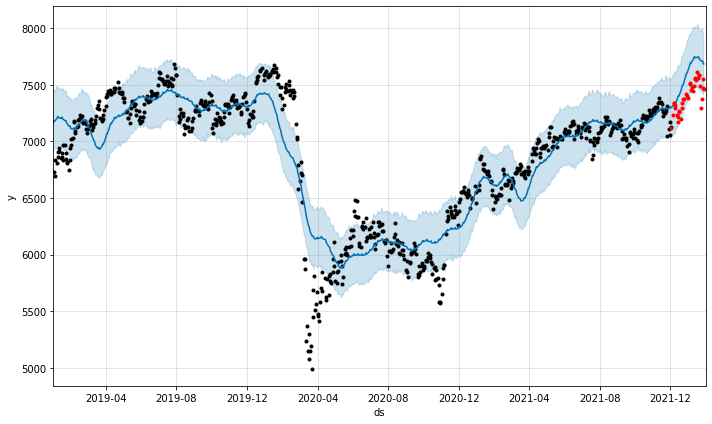

In [4]:
# Specify a cutoff day range.
days = 60

# Create a cutoff date using the days value.
today = datetime.now()
cutoff_date = today - timedelta( days )

# Use cutoff_date to split our dataset to history and actuals, which we will use to validate the model. 
history_df = ftse_prophet[ ftse_prophet['ds'] <= cutoff_date ]
actuals_df = ftse_prophet[ ftse_prophet['ds'] > cutoff_date ]

# Define the model - passing no hyperparameters results in a default model being created.
# This is bad practice in reality, but great for showing how simple Prophet is "out of the box".
model = Prophet()

# Fit the model to our history dataset.
model.fit( history_df )

# Create a future dataframe using Prophet's functon make_future_dataframe.
# Remove any non-trading (or similar days) not found in the base dataframe.
future_df = model.make_future_dataframe( periods = days, freq ='d', include_history = True )
future_df = future_df[ future_df['ds'].isin( ftse_prophet['ds'] ) ]

# Use the model to predict values for our test dataset.
forecast_df = model.predict( future_df )

# Plot the predictions, and overlay our actuals.
fig = model.plot( forecast_df )
ax = fig.gca()
ax.plot( actuals_df["ds"], actuals_df["y"], 'k.', color = "r" )
ax.set_xlim( [ datetime( 2019, 1, 1 ), today ] )

In [5]:
# Define a function to calculate the Mean Absolute Percentage Error (MAPE) - user friendly error metric.
def mape( actuals, forecast ):
  x = 0
  for i in range( actuals.index.min(), actuals.index.max()+1 ):
    x += np.abs( ( actuals[i] - forecast[i] ) / actuals[i] )
  return x / len( actuals )

# Ensure out dataframes have only corresponding entries.
forecast = forecast_df[ forecast_df['ds'].isin( actuals_df['ds'] ) ]
actuals = actuals_df[ actuals_df['ds'].isin( forecast['ds'] ) ]

# Use our MAPE function to evaluate the success of our 60 day forecast.
mape = round( 100 * mape( actuals['y'], forecast['yhat'] ), 2 )
print( f'Forecast MAPE: {mape}%' )

Forecast MAPE: 2.4%


INFO:prophet:Making 10 forecasts with cutoffs between 2019-03-18 00:00:00 and 2021-06-05 00:00:00


  0%|          | 0/10 [00:00<?, ?it/s]

Cross validation MAPE: 11.0%


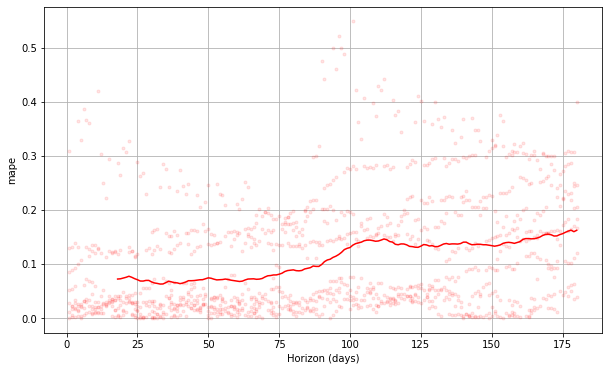

In [6]:
# Apply cross-validation on our model. This creates a forecast, for 180 days ahead, every 90 days, with 3 years of initial training data.
# As we have 5.5 years of data, this results in 8 forecasts (1 every quarter of a year, starting from 3 years -> 5 years).
crossv_df = cross_validation( model, initial = '1095 days', period = '90 days', horizon = '180 days' )

perf_df = performance_metrics( crossv_df )

# Use prophet's plot_cross_validation_metric to visualise the MAPE as the horizon increases.
fig = plot_cross_validation_metric( crossv_df, metric = 'mape', color='red' )

# Evaluate the mean MAPE for our forecasts.
crossv_mape = round( 100 * perf_df['mape'].mean(), 2 )
print( f'Cross validation MAPE: {crossv_mape}%' )